## 1. Introduction <a id="1"></a>

This notebook explores how the house prices in London have changed over the period of 1995 to 2020.

![london house](Pictures\london_houses.jpg)

### **Table of Contents**
* [Introduction](#1)
* [Data Processing](#2)
* [Data Exploration](#3)
* [House Prices Prediction](#4)

In [7]:
# Load libraries

import pandas as pd
import numpy as np

import missingno as msno
import statsmodels.api as sm

# from fbprophet import Prophet

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12

# Allows to display all of the outputs of a cell
from IPython.display import display

# Set float data type format
pd.options.display.float_format = '{:,.2f}'.format

# Set the maximum number of row to be displayed
pd.options.display.max_rows = 999

# Set global visualisation settings
plt.rc('font', size=14)

In [9]:
df = pd.read_csv('housing_in_london_monthly_variables.csv')
df_1 = pd.read_csv('housing_in_london_yearly_variables.csv')

display(df.head())
display(df_1.head())

date            area  average_price       code  houses_sold  \
0  1995-01-01  city of london          91449  E09000001        17.00   
1  1995-02-01  city of london          82203  E09000001         7.00   
2  1995-03-01  city of london          79121  E09000001        14.00   
3  1995-04-01  city of london          77101  E09000001         7.00   
4  1995-05-01  city of london          84409  E09000001        10.00   

   no_of_crimes  borough_flag  
0           NaN             1  
1           NaN             1  
2           NaN             1  
3           NaN             1  
4           NaN             1

code                  area        date  median_salary  \
0  E09000001        city of london  1999-12-01      33,020.00   
1  E09000002  barking and dagenham  1999-12-01      21,480.00   
2  E09000003                barnet  1999-12-01      19,568.00   
3  E09000004                bexley  1999-12-01      18,621.00   
4  E09000005                 brent  1999-12-01      18,532.00   

   life_satisfaction mean_salary recycling_pct  population_size  \
0                NaN       48922             0         6,581.00   
1                NaN       23620             3       162,444.00   
2                NaN       23128             8       313,469.00   
3                NaN       21386            18       217,458.00   
4                NaN       20911             6       260,317.00   

   number_of_jobs  area_size  no_of_houses  borough_flag  
0             NaN        NaN           NaN             1  
1             NaN        NaN           NaN             1  
2             NaN        NaN           NaN             1  
3             NaN        NaN           NaN             1  
4             NaN        NaN           NaN             1

## 2. Data Processing <a id="2"></a>

average_price  houses_sold  no_of_crimes  borough_flag
count      13,549.00    13,455.00      7,439.00     13,549.00
mean      263,519.68     3,893.99      2,158.35          0.73
std       187,617.50    12,114.40        902.09          0.44
min        40,722.00         2.00          0.00          0.00
25%       132,380.00       247.00      1,623.00          0.00
50%       222,919.00       371.00      2,132.00          1.00
75%       336,843.00     3,146.00      2,582.00          1.00
max     1,463,378.00   132,163.00      7,461.00          1.00

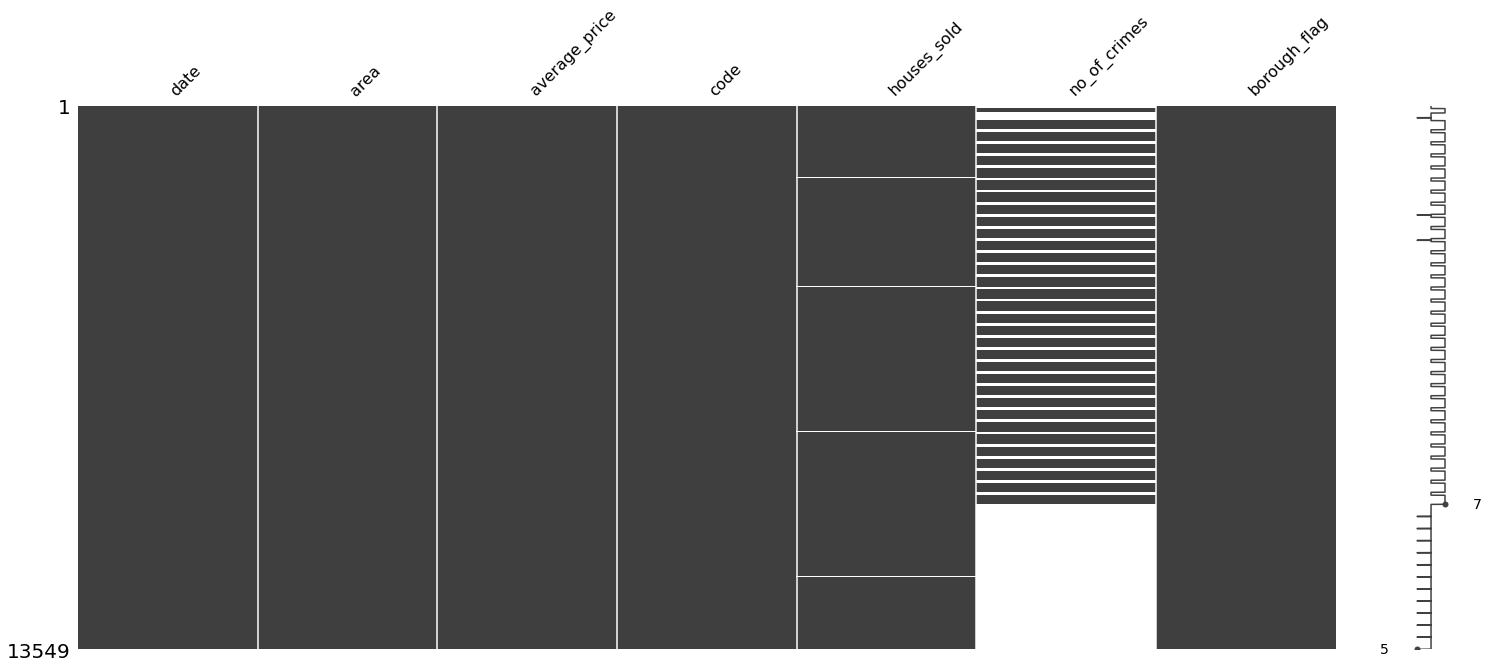

In [10]:
display(df.describe());

msno.matrix(df);

Observations:
* Yearly data is missing a few **'houses_sold'** values 
* Many values are missing for the **'no_of_crimes'** variable

median_salary  life_satisfaction  population_size  number_of_jobs  \
count       1,049.00             352.00         1,018.00          931.00   
mean       27,977.79               7.49     6,042,576.49    3,188,094.52   
std         6,412.81               0.20    15,268,096.56    8,058,302.24   
min        15,684.00               7.00         6,581.00       47,000.00   
25%        23,857.00               7.35       224,345.75       94,500.00   
50%        27,441.00               7.51       294,603.50      157,000.00   
75%        30,932.00               7.64     4,630,098.50    2,217,000.00   
max        61,636.00               7.96    66,435,550.00   35,750,000.00   

          area_size  no_of_houses  borough_flag  
count        666.00        666.00      1,071.00  
mean     372,490.27    881,468.15          0.65  
std    2,157,060.24  3,690,376.14          0.48  
min          315.00      5,009.00          0.00  
25%        2,960.00     87,635.50          0.00  
50%        4,323.00    102,402.00          1.00  
75%        8,220.00    126,276.00          1.00  
max   13,303,728.00 24,172,166.00          1.00

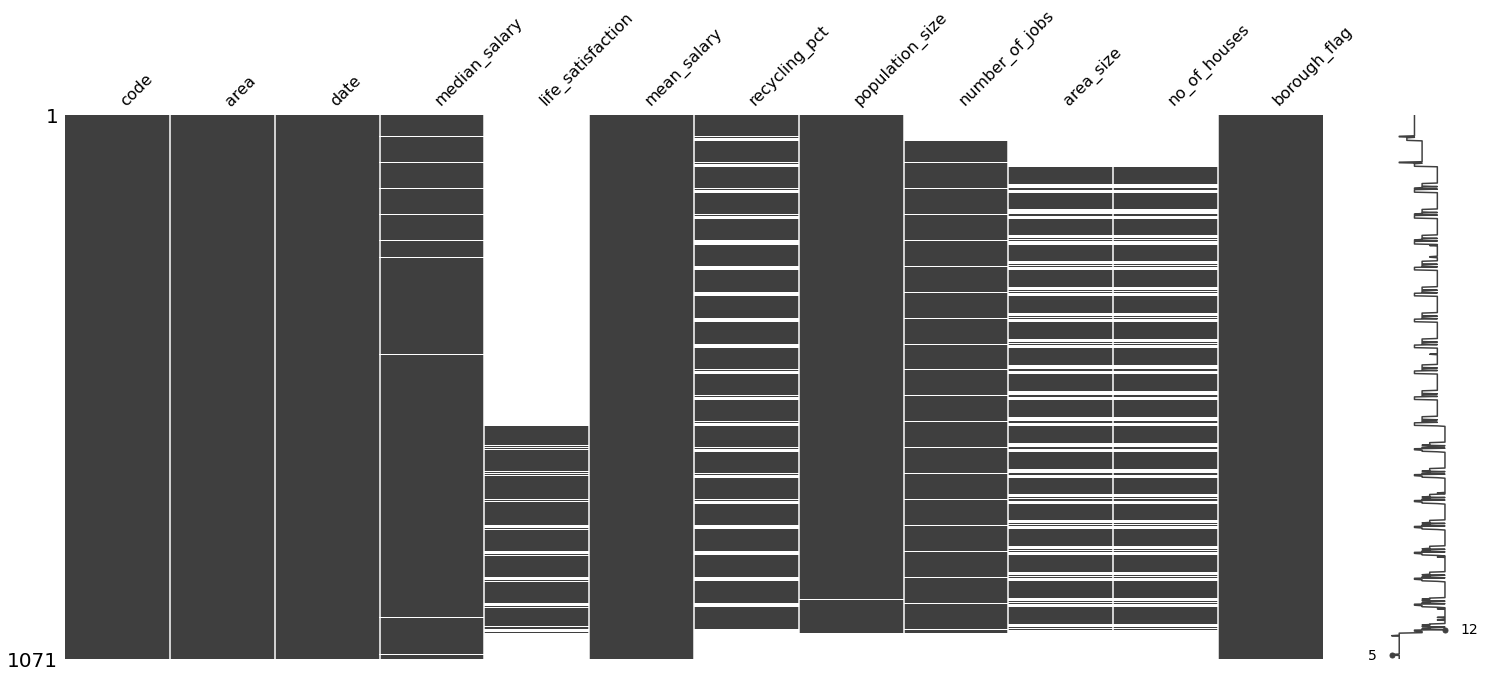

In [12]:
display(df_1.describe())

msno.matrix(df_1);

In [13]:
# Set date as index for easier manipulation
df = df.set_index(pd.to_datetime(df['date']))
df_1 = df_1.set_index(pd.to_datetime(df_1['date']))

del df['date']
del df_1['date']

df_1['mean_salary'] = df_1['mean_salary'].replace('-', np.NaN)
df_1['mean_salary'] = df_1['mean_salary'].replace('#', np.NaN)
df_1['mean_salary'] = df_1['mean_salary'].astype(float)

# Create dataset cuts
prices_london = df[df['borough_flag'] == 1]
prices_england = df[df['area'] == 'england']
prices_north_east = df[df['area'] == 'north east']

# Calcualte mean prices for the different cuts of data
london_mean_price = prices_london.groupby('date')['average_price'].mean()
england_mean_price = prices_england.groupby('date')['average_price'].mean()
north_east_mean_price = prices_north_east.groupby('date')['average_price'].mean()

print('Processing Complete')

Processing Complete


## 3. Data Exploration <a id="3"></a>

### 3.1 Main Variable Analysis

In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=london_mean_price.index, 
                         y=london_mean_price.values,
                         mode='lines',
                         name='London Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=england_mean_price.index, 
                         y=england_mean_price.values,
                         mode='lines',
                         name='England Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=north_east_mean_price.index, 
                         y=north_east_mean_price.values,
                         mode='lines',
                         name='North East Mean House Price',
                        ))


fig.update_layout(
    template='gridon',
    title='Average Monthly House Price',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    legend=dict(y=-.2, orientation='h'),
    shapes=[
        dict(
            type="line",
            x0='2016-06-01',
            x1='2016-06-01',
            y0=0,
            y1=london_mean_price.values.max()*1.2,
            line=dict(
            color="LightSalmon",
            dash="dashdot"
            )
        ),
        dict(
            type="rect",
            x0="2007-12-01",
            y0=0,
            x1="2009-06-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),
        dict(
            type="rect",
            x0="2001-03-01",
            y0=0,
            x1="2001-11-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ],
    annotations=[
            dict(text="The Great Recession", x='2007-12-01', y=london_mean_price.values.max()*1.2),
            dict(text="Brexit Vote", x='2016-06-01', y=london_mean_price.values.max()*1.2),
            dict(text="Dot-Com Bubble Recession", x='2001-03-01', y=london_mean_price.values.max()*1.2)
    ]
)

fig.show()